In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Iteration 50: Loss_D = 0.7448, Loss_G = 1.6221
Iteration 100: Loss_D = 0.0061, Loss_G = 6.3713
Iteration 150: Loss_D = 0.0026, Loss_G = 7.1759
Iteration 200: Loss_D = 0.0016, Loss_G = 7.6672


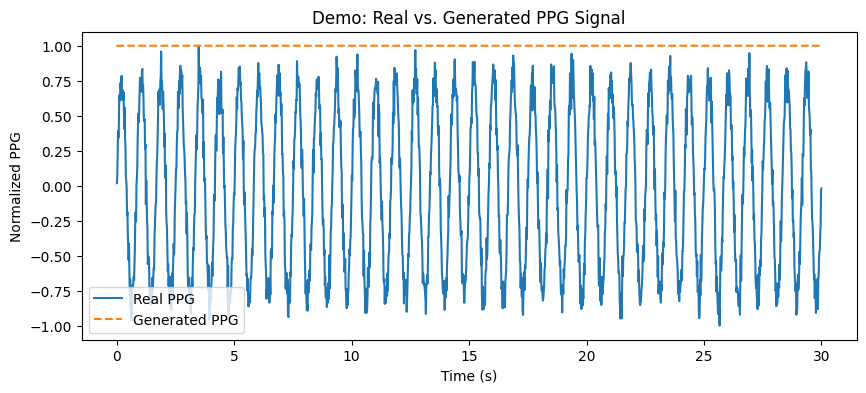

In [1]:
# %% [code]
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# %% [code]
# =============================================================================
# Dummy Data Preparation
# =============================================================================
# For a demo, we simulate a 30-second PPG signal at 60 Hz (i.e. 1800 samples)
fs = 60  # sampling frequency
duration = 30  # seconds
t = np.linspace(0, duration, fs * duration)
# Simulate a PPG-like signal: a sine wave with noise (this stands in for your extracted PPG)
real_ppg_np = np.sin(2 * np.pi * 1.2 * t) + 0.1 * np.random.randn(len(t))
# Normalize the signal between -1 and 1 (as our generator outputs Tanh activation)
real_ppg_np = (real_ppg_np - np.min(real_ppg_np)) / (np.max(real_ppg_np) - np.min(real_ppg_np))
real_ppg_np = real_ppg_np * 2 - 1

# Ground truth BP values (from your VV sample GT file, here simulated)
gt_bp_sys = 135  # systolic BP (mmHg)
gt_bp_dia = 84   # diastolic BP (mmHg)

# Convert the real PPG signal to a PyTorch tensor with shape: [batch, channels, length]
# Here batch=1 and channels=1 (for a single-channel signal)
real_ppg = torch.tensor(real_ppg_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# %% [code]
# =============================================================================
# Define the GAN components: Generator, Discriminator, and Q network (for InfoGAN)
# =============================================================================

# In InfoGAN, we condition the generator on a latent code.
# In our demo, we simulate a latent code vector that might represent controlled factors (e.g. age, BMI).
latent_code_dim = 4  # dimensionality of the latent code (adjust as needed)
noise_dim = 8        # dimensionality of the incompressible noise
# For the demo, we use a fixed latent code (in a real scenario, this might be based on a mapping table)
latent_code = torch.rand((1, latent_code_dim))  # shape: [batch, latent_code_dim]

# Our generator will be conditioned on both noise and the latent code.
# We do this by concatenating the noise and a tiled version of the latent code along the channel dimension.
# Therefore, the generator input channels = noise_dim + latent_code_dim.

output_length = real_ppg.shape[2]  # should be 1800 for our demo

class Generator(nn.Module):
    def __init__(self, in_channels, output_length):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=3, padding=1),
            nn.Tanh()  # outputs in [-1,1]
        )
        self.output_length = output_length

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # probability output
        )

    def forward(self, x):
        return self.net(x)

class QHead(nn.Module):
    """Auxiliary network to recover latent code from generated signal."""
    def __init__(self, latent_dim):
        super(QHead, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(32, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate models
input_channels = noise_dim + latent_code_dim  # total channels after concatenation
G = Generator(input_channels, output_length)
D = Discriminator()
Q = QHead(latent_code_dim)

# %% [code]
# =============================================================================
# Utility: Create generator input by concatenating noise and latent code
# =============================================================================
def sample_generator_input(batch_size, noise_dim, latent_code):
    # Sample noise: shape [batch, noise_dim, output_length]
    z_noise = torch.randn(batch_size, noise_dim, output_length)
    # Tile the latent code along the time dimension: shape [batch, latent_code_dim, output_length]
    latent_channel = latent_code.unsqueeze(2).repeat(1, 1, output_length)
    # Concatenate along channel dimension
    z_input = torch.cat([z_noise, latent_channel], dim=1)
    return z_input

# %% [code]
# =============================================================================
# Set up optimizers and loss functions
# =============================================================================
lr = 0.002
optim_G = optim.Adam(G.parameters(), lr=lr)
optim_D = optim.Adam(D.parameters(), lr=lr)
optim_Q = optim.Adam(Q.parameters(), lr=lr)

criterion = nn.BCELoss()   # for GAN (real vs fake)
mse_loss = nn.MSELoss()    # for mutual information loss

# %% [code]
# =============================================================================
# Training loop (demo over a few iterations)
# =============================================================================
num_iterations = 200  # short training for demo
batch_size = 1

# Labels for real and fake data
real_label = torch.ones(batch_size, 1)
fake_label = torch.zeros(batch_size, 1)

for i in range(num_iterations):
    # -------------------------
    # Train Discriminator
    # -------------------------
    optim_D.zero_grad()
    
    # Discriminator on real data
    d_real = D(real_ppg)
    loss_real = criterion(d_real, real_label)
    
    # Generate fake data
    z_input = sample_generator_input(batch_size, noise_dim, latent_code)
    fake_ppg = G(z_input)
    d_fake = D(fake_ppg.detach())
    loss_fake = criterion(d_fake, fake_label)
    
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optim_D.step()
    
    # -------------------------
    # Train Generator and Q (InfoGAN branch)
    # -------------------------
    optim_G.zero_grad()
    optim_Q.zero_grad()
    
    d_fake_for_G = D(fake_ppg)
    loss_G_adv = criterion(d_fake_for_G, real_label)  # try to fool D
    
    # Mutual information loss: Q tries to recover the latent code from fake_ppg
    recovered_latent = Q(fake_ppg)
    loss_info = mse_loss(recovered_latent, latent_code)
    
    # Total generator loss: adversarial + info loss (lambda set to 1 for demo)
    loss_G = loss_G_adv + 1.0 * loss_info
    loss_G.backward()
    optim_G.step()
    optim_Q.step()
    
    # Print losses every 50 iterations
    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}: Loss_D = {loss_D.item():.4f}, Loss_G = {loss_G.item():.4f}")

# %% [code]
# =============================================================================
# Plot the real vs generated PPG signal
# =============================================================================
# Generate one synthetic PPG signal
with torch.no_grad():
    generated_ppg = G(sample_generator_input(1, noise_dim, latent_code)).detach().numpy().squeeze()

# Plotting the signals
plt.figure(figsize=(10, 4))
plt.plot(t, real_ppg_np, label="Real PPG")
plt.plot(t, generated_ppg, label="Generated PPG", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Normalized PPG")
plt.title("Demo: Real vs. Generated PPG Signal")
plt.legend()
plt.show()


Dataset Columns: ['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)', 'Weight(kg)', 'Systolic Blood Pressure(mmHg)', 'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)', 'Hypertension', 'Diabetes', 'cerebral infarction', 'cerebrovascular disease']
   Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0     1           2   Female         45         152          63   
1     2           3   Female         50         157          50   
2     3           6   Female         47         150          47   
3     4           8     Male         45         172          65   
4     5           9   Female         46         155          65   

   Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                            161                              89   
1                            160                              93   
2                            101                              71   
3                            136                     

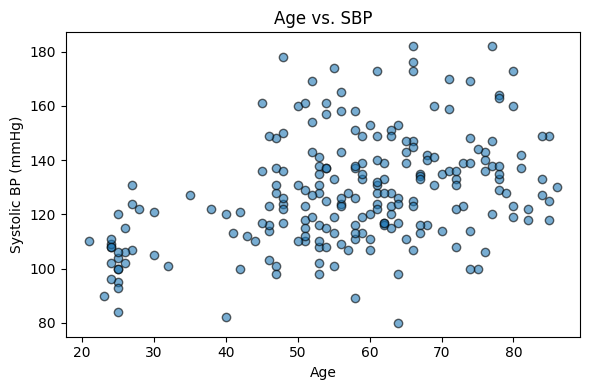

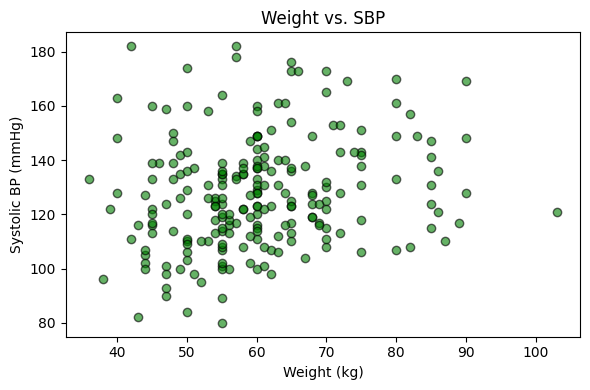

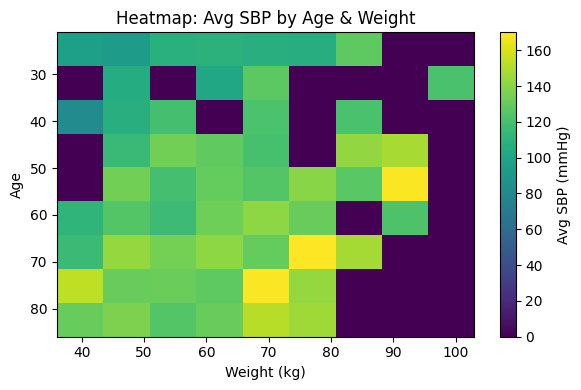

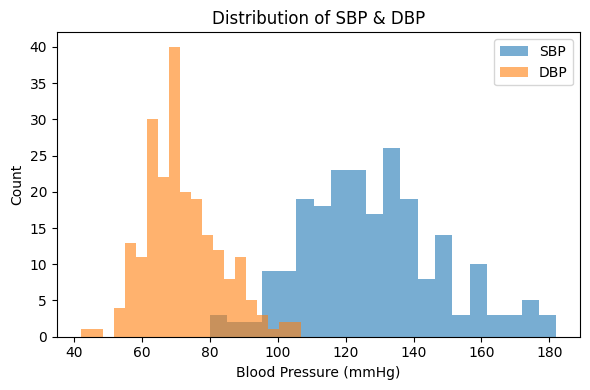

Epoch [10/100] - Loss: 645.0565
Epoch [20/100] - Loss: 522.8350
Epoch [30/100] - Loss: 545.4577
Epoch [40/100] - Loss: 531.2562
Epoch [50/100] - Loss: 523.9321
Epoch [60/100] - Loss: 526.8454
Epoch [70/100] - Loss: 524.0793
Epoch [80/100] - Loss: 580.6751
Epoch [90/100] - Loss: 531.4504
Epoch [100/100] - Loss: 546.2947


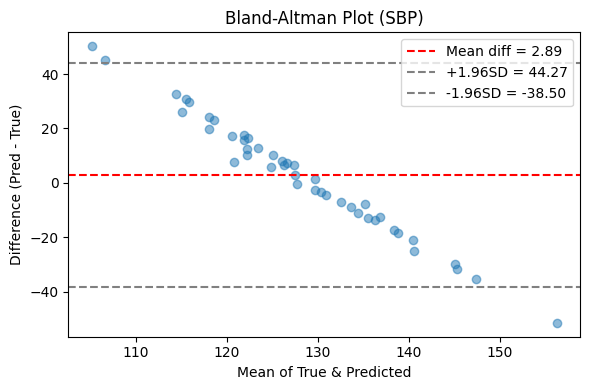

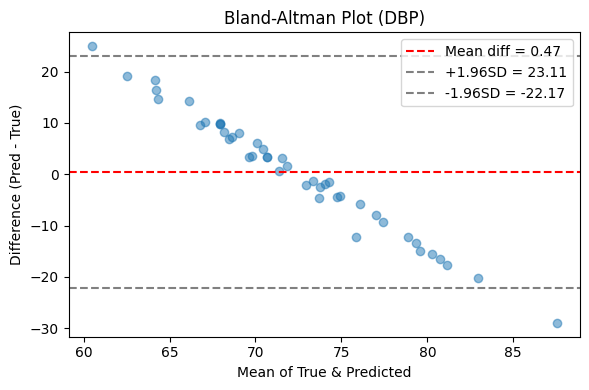

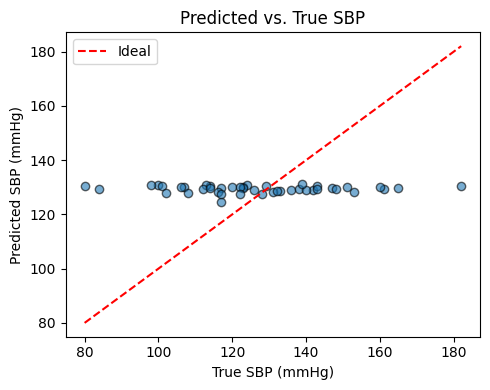

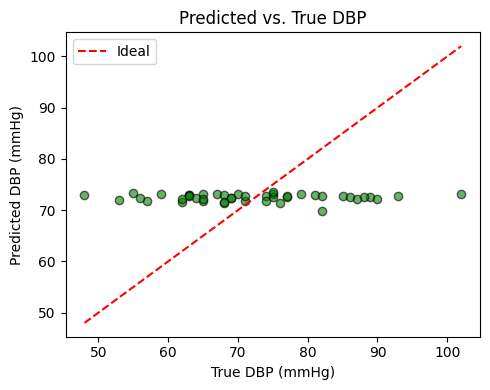

SBP: Mean Absolute Error = 17.16 mmHg, Std = 21.11 mmHg
DBP: Mean Absolute Error = 9.43 mmHg, Std = 11.55 mmHg


In [1]:
# %% [code]
# =========================
# 1. Imports & Helper Functions
# =========================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from scipy.stats import skew

# Signal quality index based on skewness
def compute_ssqi(ppg_signal):
    """Compute the Skewness Signal Quality Index (SSQI) for a given PPG signal."""
    N = len(ppg_signal)
    mean_val = np.mean(ppg_signal)
    std_val = np.std(ppg_signal)
    if std_val < 1e-12:
        return 0.0
    return np.sum(((ppg_signal - mean_val) / std_val) ** 3) / N

def load_ppg_segment(file_path):
    """
    Load a PPG segment from a text file.
    Modify this function if your file format is different.
    """
    try:
        ppg = np.loadtxt(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.array([])
    return ppg

# %% [code]
# =========================
# 2. Custom Dataset Class: Loads Excel file info and PPG segments
# =========================
class PPGBP_Dataset(Dataset):
    def __init__(self, excel_path, data_dir):
        """
        Args:
            excel_path (str): Path to the Excel file with subject info.
            data_dir (str): Directory containing PPG text files (e.g., "subject/2_1.txt", etc.)
        """
        # Read the Excel file; assume header row is row 2 (header=1)
        self.data_info = pd.read_excel(excel_path, header=1)
        print("Dataset Columns:", self.data_info.columns.tolist())
        print(self.data_info.head())
        
        # Required columns (adjust as needed):
        required_cols = ["subject_ID", "Systolic Blood Pressure(mmHg)", "Diastolic Blood Pressure(mmHg)", "Age(year)", "Weight(kg)"]
        for col in required_cols:
            if col not in self.data_info.columns:
                raise ValueError(f"Missing required column: {col}")
        
        self.samples = []
        for idx, row in self.data_info.iterrows():
            subject_id = str(row["subject_ID"])
            sbp = row["Systolic Blood Pressure(mmHg)"]
            dbp = row["Diastolic Blood Pressure(mmHg)"]
            age = row["Age(year)"]
            weight = row["Weight(kg)"]
            
            # Construct potential file names (e.g., "2_1.txt", "2_2.txt", "2_3.txt")
            segment_files = [
                os.path.join(data_dir, f"{subject_id}_1.txt"),
                os.path.join(data_dir, f"{subject_id}_2.txt"),
                os.path.join(data_dir, f"{subject_id}_3.txt")
            ]
            ssqi_list = []
            ppg_segments = []
            for f in segment_files:
                if not os.path.exists(f):
                    ssqi_list.append(-9999)
                    ppg_segments.append(np.array([]))
                    continue
                ppg_signal = load_ppg_segment(f)
                ssqi = compute_ssqi(ppg_signal)
                ssqi_list.append(ssqi)
                ppg_segments.append(ppg_signal)
            
            best_idx = np.argmax(ssqi_list)
            best_ppg = ppg_segments[best_idx]
            if len(best_ppg) == 0:
                continue  # Skip subject if no valid segment
            
            # Normalize the PPG signal: zero mean, unit variance
            best_ppg = (best_ppg - np.mean(best_ppg)) / (np.std(best_ppg) + 1e-12)
            
            sample = {
                'subject_id': subject_id,
                'ppg': best_ppg.astype(np.float32),
                'sbp': np.float32(sbp),
                'dbp': np.float32(dbp),
                'age': age,
                'weight': weight
            }
            self.samples.append(sample)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        # Return PPG tensor with shape (1, length)
        ppg_tensor = torch.tensor(sample['ppg']).unsqueeze(0)
        sbp_tensor = torch.tensor(sample['sbp'])
        dbp_tensor = torch.tensor(sample['dbp'])
        age = sample['age']
        weight = sample['weight']
        return ppg_tensor, sbp_tensor, dbp_tensor, age, weight

# %% [code]
# =========================
# 3. Visualization: Mapping and Distributions
# =========================
def visualize_mapping(dataset):
    ages = [s['age'] for s in dataset.samples]
    weights = [s['weight'] for s in dataset.samples]
    sbp_vals = [s['sbp'] for s in dataset.samples]
    
    # Scatter: Age vs SBP
    plt.figure(figsize=(6,4))
    plt.scatter(ages, sbp_vals, alpha=0.6, edgecolor='black')
    plt.xlabel("Age")
    plt.ylabel("Systolic BP (mmHg)")
    plt.title("Age vs. SBP")
    plt.tight_layout()
    plt.show()
    
    # Scatter: Weight vs SBP
    plt.figure(figsize=(6,4))
    plt.scatter(weights, sbp_vals, alpha=0.6, color='green', edgecolor='black')
    plt.xlabel("Weight (kg)")
    plt.ylabel("Systolic BP (mmHg)")
    plt.title("Weight vs. SBP")
    plt.tight_layout()
    plt.show()
    
    # 2D Heatmap: Bin Age & Weight, average SBP
    age_bins = np.linspace(min(ages), max(ages), 10)
    weight_bins = np.linspace(min(weights), max(weights), 10)
    heatmap = np.zeros((len(age_bins)-1, len(weight_bins)-1))
    counts = np.zeros_like(heatmap)
    
    for s in dataset.samples:
        age_val = s['age']
        weight_val = s['weight']
        sbp_val = s['sbp']
        # Find bin indices
        age_idx = np.digitize(age_val, age_bins) - 1
        weight_idx = np.digitize(weight_val, weight_bins) - 1
        # Ensure index in range
        age_idx = min(max(age_idx, 0), heatmap.shape[0]-1)
        weight_idx = min(max(weight_idx, 0), heatmap.shape[1]-1)
        heatmap[age_idx, weight_idx] += sbp_val
        counts[age_idx, weight_idx] += 1
    
    avg_heatmap = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts>0)
    
    plt.figure(figsize=(6,4))
    plt.imshow(avg_heatmap, cmap='viridis', aspect='auto', 
               extent=[weight_bins[0], weight_bins[-1], age_bins[-1], age_bins[0]])
    plt.colorbar(label="Avg SBP (mmHg)")
    plt.xlabel("Weight (kg)")
    plt.ylabel("Age")
    plt.title("Heatmap: Avg SBP by Age & Weight")
    plt.tight_layout()
    plt.show()
    
    # Distribution histograms for SBP and DBP
    sbp_list = [s['sbp'] for s in dataset.samples]
    dbp_list = [s['dbp'] for s in dataset.samples]
    
    plt.figure(figsize=(6,4))
    plt.hist(sbp_list, bins=20, alpha=0.6, label='SBP')
    plt.hist(dbp_list, bins=20, alpha=0.6, label='DBP')
    plt.xlabel("Blood Pressure (mmHg)")
    plt.ylabel("Count")
    plt.title("Distribution of SBP & DBP")
    plt.legend()
    plt.tight_layout()
    plt.show()

# %% [code]
# =========================
# 4. Model Definition: Backbone (F) and Regression Head (B)
# =========================
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        # 1D convolutional encoder with 5 layers (inspired by paper)
        self.conv1 = nn.Conv1d(1, 8, kernel_size=5, padding=2)
        self.prelu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(8, 16, kernel_size=5, padding=2)
        self.prelu2 = nn.PReLU()
        self.conv3 = nn.Conv1d(16, 24, kernel_size=5, padding=2)
        self.prelu3 = nn.PReLU()
        self.conv4 = nn.Conv1d(24, 32, kernel_size=5, padding=2)
        self.prelu4 = nn.PReLU()
        self.conv5 = nn.Conv1d(32, 40, kernel_size=5, padding=2)
        self.prelu5 = nn.PReLU()
        # Global Average Pooling over time dimension
        self.gap = nn.AdaptiveAvgPool1d(1)
    
    def forward(self, x):
        # x: (batch, 1, length)
        x = self.prelu1(self.conv1(x))
        x = self.prelu2(self.conv2(x))
        x = self.prelu3(self.conv3(x))
        x = self.prelu4(self.conv4(x))
        x = self.prelu5(self.conv5(x))
        x = self.gap(x)
        x = x.squeeze(2)  # -> (batch, 40)
        return x

class RegressionHead(nn.Module):
    def __init__(self, in_features=40):
        super(RegressionHead, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.prelu = nn.PReLU()
        self.fc_dbp = nn.Linear(64, 1)  # Predict diastolic BP
        self.fc_pp = nn.Linear(64, 1)   # Predict pulse pressure
    def forward(self, x):
        x = self.prelu(self.fc1(x))
        e_dbp = self.fc_dbp(x)
        e_pp = self.fc_pp(x)
        e_sbp = e_dbp + e_pp  # systolic = diastolic + pulse pressure
        return e_sbp, e_dbp, e_pp

class BP_Estimator(nn.Module):
    def __init__(self):
        super(BP_Estimator, self).__init__()
        self.backbone = Backbone()
        self.regressor = RegressionHead()
    def forward(self, x):
        features = self.backbone(x)
        e_sbp, e_dbp, e_pp = self.regressor(features)
        return e_sbp, e_dbp, e_pp

# %% [code]
# =========================
# 5. Training & Evaluation Pipeline
# =========================

# Adjust these paths for your Kaggle environment:
excel_path = "/kaggle/input/ppg-bp-excel/PPG-BP dataset.xlsx"  # Uploaded Excel file
data_dir   = "/kaggle/input/ppg-bp-excel/0_subject/0_subject"         # Directory with subject text files

# Create dataset and visualize mappings
dataset = PPGBP_Dataset(excel_path, data_dir)
print(f"Total subjects with valid data: {len(dataset)}")
visualize_mapping(dataset)

# Group splitting: use subject_id as group to avoid data leakage.
subject_ids = [s['subject_id'] for s in dataset.samples]
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(np.zeros(len(dataset)), None, groups=subject_ids))

from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BP_Estimator().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop: We use loss on predicted SBP and DBP.
num_epochs = 100  # adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for ppg_batch, sbp_batch, dbp_batch, _, _ in train_loader:
        ppg_batch = ppg_batch.to(device)
        sbp_batch = sbp_batch.to(device)
        dbp_batch = dbp_batch.to(device)
        optimizer.zero_grad()
        e_sbp, e_dbp, e_pp = model(ppg_batch)
        # Compute loss: MSE for SBP and DBP
        loss_sbp = criterion(e_sbp.squeeze(), sbp_batch)
        loss_dbp = criterion(e_dbp.squeeze(), dbp_batch)
        loss = loss_sbp + loss_dbp
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ppg_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

# Evaluation on test set
model.eval()
pred_sbp_list = []
true_sbp_list = []
pred_dbp_list = []
true_dbp_list = []
with torch.no_grad():
    for ppg_batch, sbp_batch, dbp_batch, _, _ in test_loader:
        ppg_batch = ppg_batch.to(device)
        e_sbp, e_dbp, _ = model(ppg_batch)
        pred_sbp_list.append(e_sbp.squeeze().item())
        true_sbp_list.append(sbp_batch.item())
        pred_dbp_list.append(e_dbp.squeeze().item())
        true_dbp_list.append(dbp_batch.item())

# %% [code]
# =========================
# 6. Evaluation Visualization Utilities
# =========================
def bland_altman_plot(true_vals, pred_vals, title="Bland-Altman Plot"):
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    mean_vals = (true_vals + pred_vals) / 2.0
    diff_vals = pred_vals - true_vals
    md = np.mean(diff_vals)
    sd = np.std(diff_vals)
    
    plt.figure(figsize=(6,4))
    plt.scatter(mean_vals, diff_vals, alpha=0.5)
    plt.axhline(md, color='red', linestyle='--', label=f"Mean diff = {md:.2f}")
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--', label=f"+1.96SD = {md+1.96*sd:.2f}")
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--', label=f"-1.96SD = {md-1.96*sd:.2f}")
    plt.title(title)
    plt.xlabel("Mean of True & Predicted")
    plt.ylabel("Difference (Pred - True)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_error_hist(true_vals, pred_vals, title="Error Distribution"):
    errors = np.array(pred_vals) - np.array(true_vals)
    plt.figure(figsize=(6,4))
    plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Error (Pred - True)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Bland-Altman for SBP
bland_altman_plot(true_sbp_list, pred_sbp_list, title="Bland-Altman Plot (SBP)")

# Bland-Altman for DBP
bland_altman_plot(true_dbp_list, pred_dbp_list, title="Bland-Altman Plot (DBP)")

# Scatter plots: True vs Predicted
plt.figure(figsize=(5,4))
plt.scatter(true_sbp_list, pred_sbp_list, alpha=0.6, edgecolor='black')
plt.plot([min(true_sbp_list), max(true_sbp_list)], [min(true_sbp_list), max(true_sbp_list)], 'r--', label="Ideal")
plt.xlabel("True SBP (mmHg)")
plt.ylabel("Predicted SBP (mmHg)")
plt.title("Predicted vs. True SBP")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.scatter(true_dbp_list, pred_dbp_list, alpha=0.6, color='green', edgecolor='black')
plt.plot([min(true_dbp_list), max(true_dbp_list)], [min(true_dbp_list), max(true_dbp_list)], 'r--', label="Ideal")
plt.xlabel("True DBP (mmHg)")
plt.ylabel("Predicted DBP (mmHg)")
plt.title("Predicted vs. True DBP")
plt.legend()
plt.tight_layout()
plt.show()

# Print summary error statistics
sbp_errors = np.array(pred_sbp_list) - np.array(true_sbp_list)
dbp_errors = np.array(pred_dbp_list) - np.array(true_dbp_list)
print(f"SBP: Mean Absolute Error = {np.mean(np.abs(sbp_errors)):.2f} mmHg, Std = {np.std(sbp_errors):.2f} mmHg")
print(f"DBP: Mean Absolute Error = {np.mean(np.abs(dbp_errors)):.2f} mmHg, Std = {np.std(dbp_errors):.2f} mmHg")
